### Import extract.csv file and perform preprocessing

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.offsetbox import AnchoredText
%matplotlib inline
import itertools

sns.set(style="ticks", color_codes=True)

def to_celsius(x):
    x = float(x)
    return round((x-32)*5/9,1)

df = pd.read_csv('extract.csv')
# Sory by date and hr
df.sort_values(by=['date','hr'], inplace=True, ascending=True)
df['temperature'] = df['temperature'].apply(to_celsius)
df['feels_like_temperature'] = df['feels_like_temperature'].apply(to_celsius)
df['total_scooter_users'] = df['guest_scooter'] + df['registered_scooter'] 

# Fix spelling errors in weather
df['weather'] = df['weather'].str.lower().replace('lear','clear').replace('clar','clear')
df['weather'] = df['weather'].str.replace('loudy','cloudy').replace('ccloudy','cloudy').replace('cludy','cloudy')
df['weather'] = df['weather'].str.replace('liht snow/rain','light snow/rain')
df['date_hr'] = pd.to_datetime(df['date']) + df['hr'].astype('timedelta64[h]')

df = df.reset_index(drop=True)

# Fill NaN and negative values to 0
df.fillna(0)
num = df._get_numeric_data()
num[num < 0] = 0

df.head()

,date,hr,weather,temperature,feels_like_temperature,relative_humidity,windspeed,psi,guest_scooter,registered_scooter,total_scooter_users,date_hr
0,2011-01-01,0,clear,19.3,35.0,81.0,0.0,50,7,90,97,2011-01-01 00:00:00
1,2011-01-01,1,clear,18.3,34.0,80.0,0.0,6,23,224,247,2011-01-01 01:00:00
2,2011-01-01,2,clear,18.3,34.0,80.0,0.0,25,14,188,202,2011-01-01 02:00:00
3,2011-01-01,3,clear,19.3,35.0,75.0,0.0,41,9,70,79,2011-01-01 03:00:00
4,2011-01-01,3,clear,19.3,35.0,75.0,0.0,41,9,70,79,2011-01-01 03:00:00


In [2]:
df.describe(include='all')

,date,hr,weather,temperature,feels_like_temperature,relative_humidity,windspeed,psi,guest_scooter,registered_scooter,total_scooter_users,date_hr
count,18643,18643.000000,18643,18643.000000,18643.000000,18643.000000,18643.000000,18643.000000,18643.000000,18643.000000,18643.000000,18643
unique,731,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17031
top,2011-11-07,NaN,clear,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-06-24 02:00:00
freq,32,NaN,12277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-12-31 23:00:00
mean,NaN,11.537145,NaN,31.351236,47.396449,62.733251,12.741082,25.142198,106.440916,1074.471973,1180.860430,NaN
std,NaN,6.924281,NaN,9.029737,11.313379,19.315897,8.217008,14.442978,147.113777,1055.916333,1137.171473,NaN
min,NaN,0.000000,NaN,8.900000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,6.000000,NaN,24.000000,38.000000,48.000000,7.000000,13.000000,12.000000,240.000000,258.000000,NaN


### List of functions to generate plots

In [64]:
def generate_avg_hourly_yyyymm_line_plots(df, attribute_a, attribute_b, yr):
    
    '''Generates line plots for each month, comparing the average values of 
       attribute_a vs attribute_b at each hour in a day'''
    
    assert (type(attribute_a),type(attribute_b),type(yr)) == (str,str,int)
    
    plot_df = df.copy(deep=True)
    plot_df['date'] = pd.to_datetime(plot_df['date'])
    plot_df['date'] = plot_df['date'].dt.to_period('M')
    plot_df_yr = plot_df[plot_df['date'].dt.year == yr]
    plot_df_avg_yr = plot_df_yr.groupby(['date','hr']).mean().reset_index()

    mth_ls = [mth for mth in plot_df_avg_yr.date.dt.strftime('%Y-%m').unique()]

    fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(15,25))

    ind = 0
    for row in range(6):
        for col in range(2):
            # Generate SubPlots
            plot_mth = plot_df_avg_yr[plot_df_avg_yr.date == mth_ls[ind]]
            x = plot_mth['hr']
            y_1 = plot_mth[attribute_a]
            y_2 = plot_mth[attribute_b]

            ax_2 = ax[row,col].twinx()

            ax[row,col].plot(x, y_1)
            ax_2.plot(x, y_2, 'r--')

            ax[row,col].set_xticks(x)
            ax[row,col].set_title(mth_ls[ind],fontsize=12)
            ax[row,col].set_xlabel('hour', fontsize=12)
            ax[row,col].set_ylabel('monthly avg. ' + attribute_a, fontsize=12)
            ax[row,col].legend([attribute_a],loc='lower left')
            ax_2.set_ylabel('monthly avg. '+ attribute_b, fontsize=12)
            ax_2.legend([attribute_b],loc='lower right' )

            ind += 1
    plt.legend([attribute_a,attribute_b])
    plt.tight_layout()
    plt.show()
    
def test_stationarity(df, attribute, period_frm, period_to):
    '''
    Test to assess whether the timeseries data is stationary
    '''
    ts_df = df.copy(deep=True)
    ts_df = ts_df.groupby(['date_hr']).mean().reset_index()
    ts_df.set_index('date_hr', inplace=True)
    ts_df = ts_df[attribute]
    
    timeseries = ts_df.loc[period_frm : period_to]
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(20,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation for ' + attribute, fontsize = 15)
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test for '+ attribute + ':')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    print(dfoutput)
    
    
def generate_autocorrelation_plot(df, attribute, period_frm, period_to):

    ts_df = df.copy(deep=True)
    ts_df = ts_df.groupby(['date_hr']).mean().reset_index()
    ts_df.set_index('date_hr', inplace=True)
    ts_df = ts_df[attribute]
    
    timeseries = ts_df.loc[period_frm : period_to]
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
    plot_acf(timeseries, ax=ax[0], title=None)
    plot_pacf(timeseries, ax=ax[1], title= None)
    
    ax[0].set_title('Autocorrelation Plot for '+ attribute , fontsize=15)
    ax[1].set_title('Partial Autocorrelation Plot for ' + attribute , fontsize=15)
    plt.show()

### Temperature vs Relative Humidity
Comparing temperature and relative humidity, it looks like in the early morning (0hr-9hr), its more humid, so the tempeature is lower, but between afternoon to evening (13hr to 20hr), its less humid, so the temperature is higher. Pattern looks consistent for each month and year

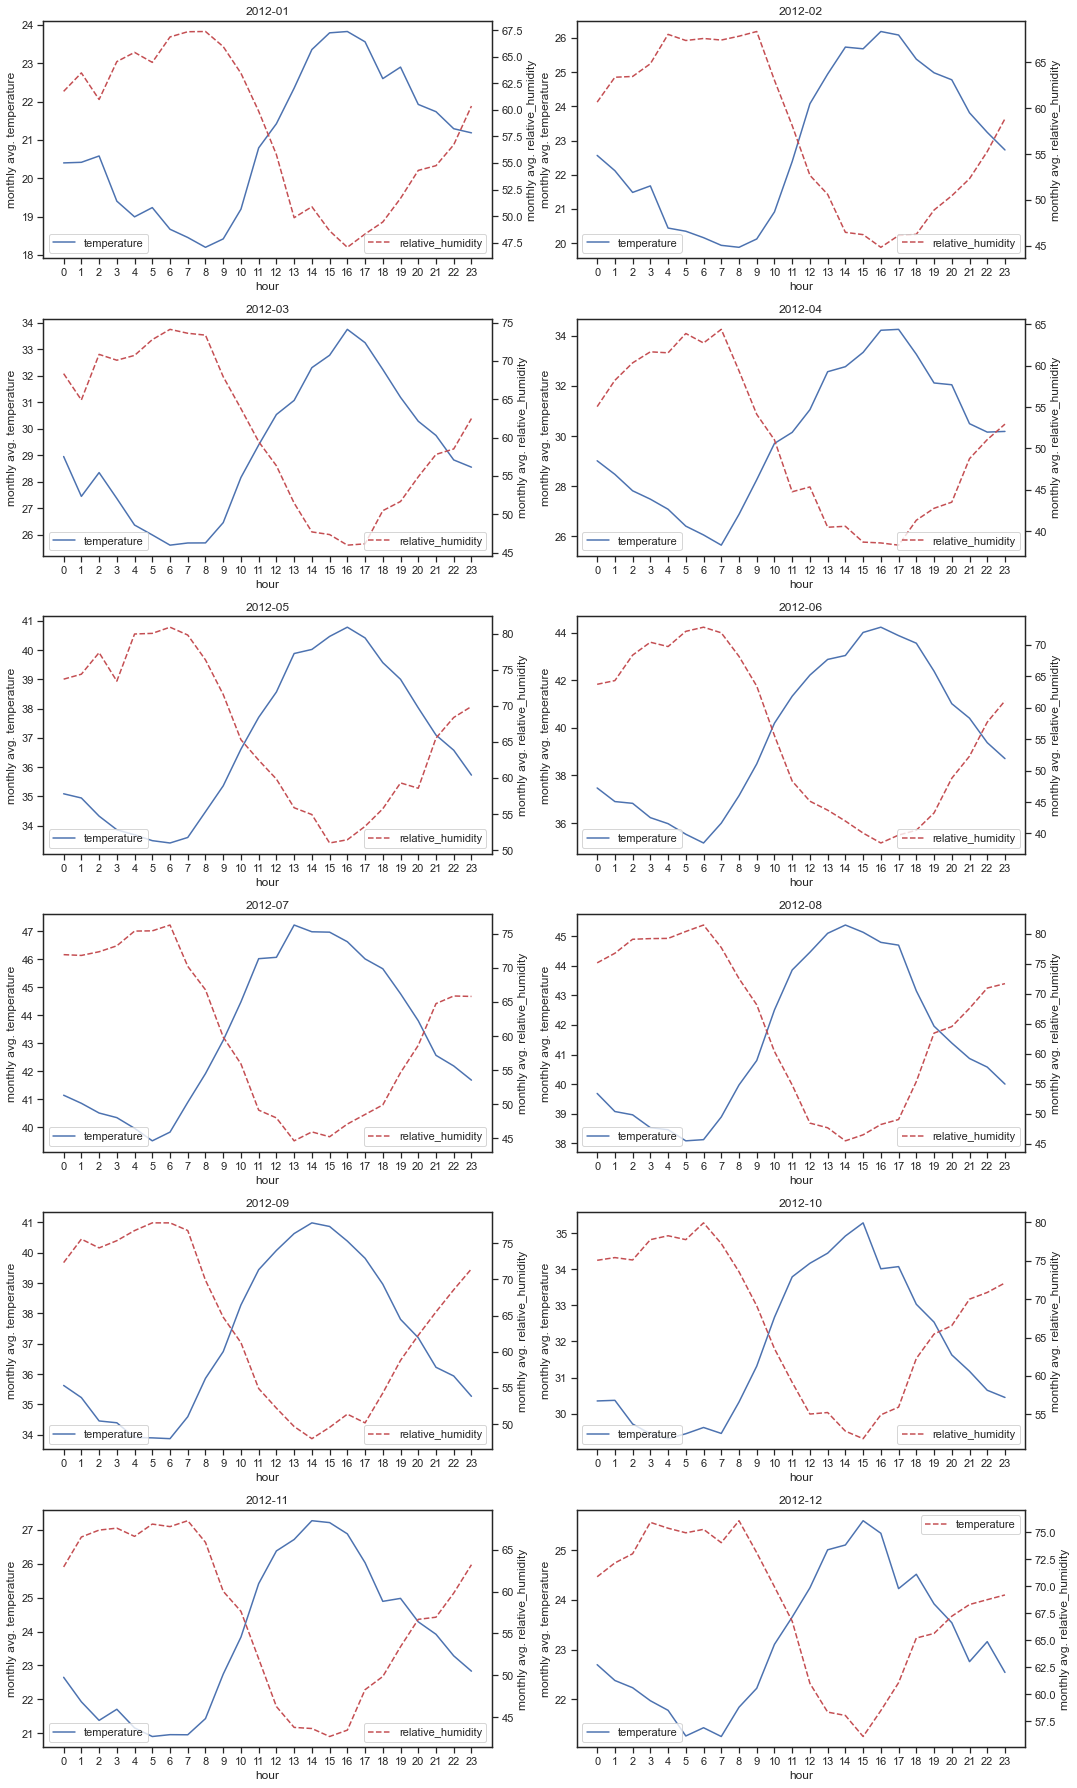

In [4]:
generate_avg_hourly_yyyymm_line_plots(df, 'temperature','relative_humidity',2012)

### PSI vs Wind Speed
It looks like windspeed speeds up between afternoon and evening in a day (10hr to 20hr), this pattern is consistent each month and year. However for PSI, it looks like it varies without any pattern for each month and year

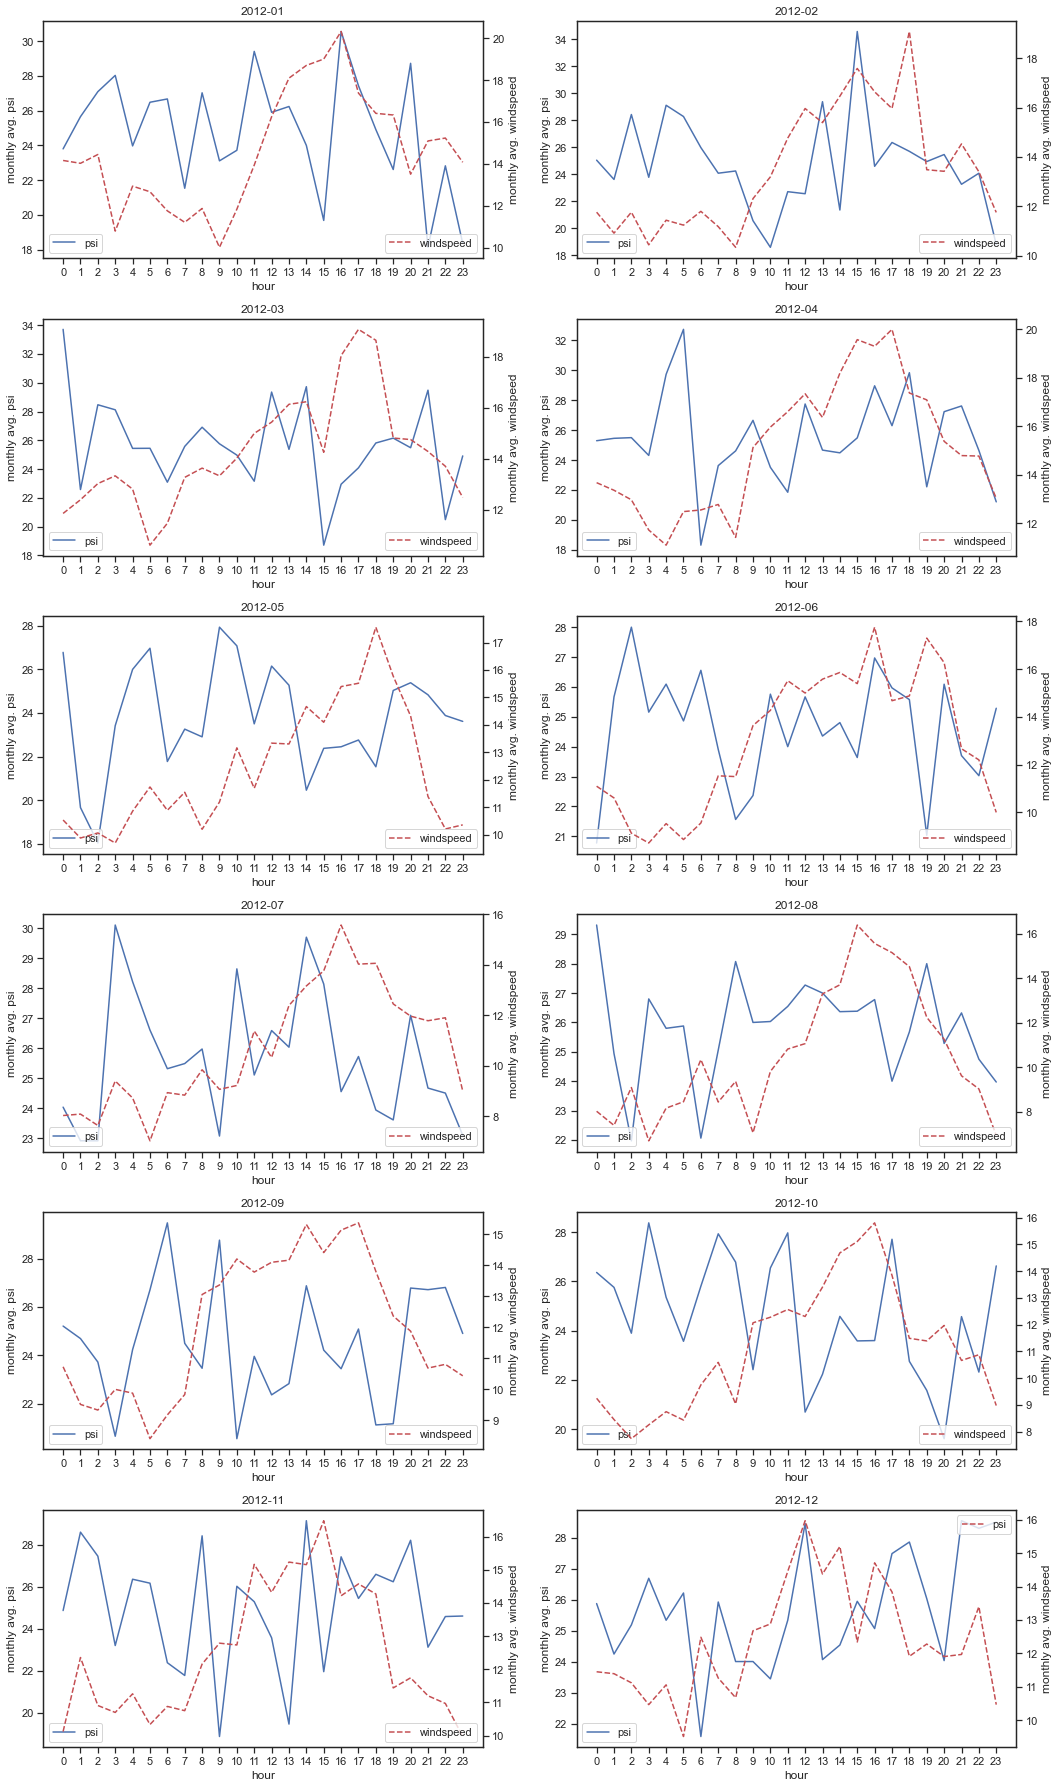

In [5]:
generate_avg_hourly_yyyymm_line_plots(df, 'psi','windspeed',2012)

### Feels Like Temp vs Total E-Scooter Rentals
In terms of tracking users renting bikes, there is a peak in the morning (7hr - 9hr) and evening (16hr - 20hr), this pattern is consistent for each month and year. Apparently, the "feels like temperature", doesnt affect the timing of the bike rental. Likely those 2 peaks are to get to work/go home

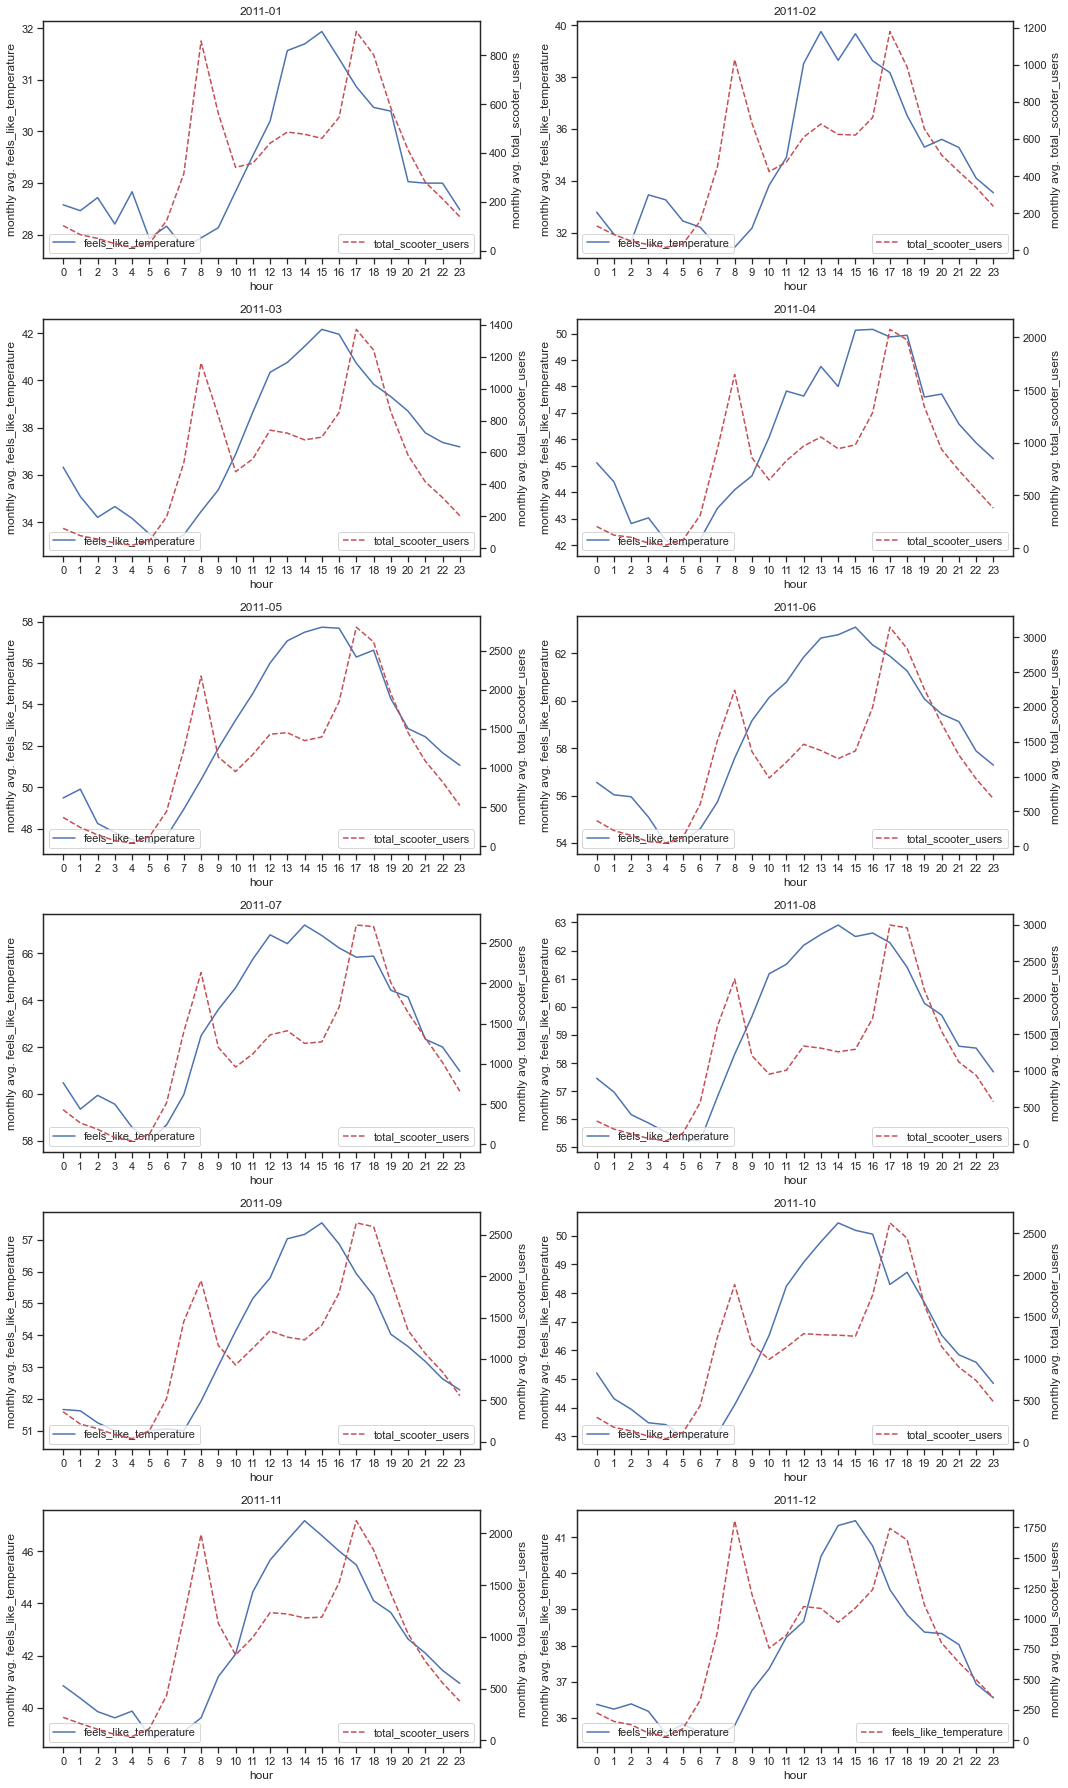

In [6]:
generate_avg_hourly_yyyymm_line_plots(df, 'feels_like_temperature','total_scooter_users',2011)

### Guest Scooter vs Registered Scooter
Registered rental users follow the similar pattern, which is a peak in the morning (7hr - 9hr) and evening (16hr - 20hr). However, the guest users turned out to be most active in the afternoon (11hr - 16hr), if the scooter rentals are registered via a mobile/web application, its likely in these period they are most active

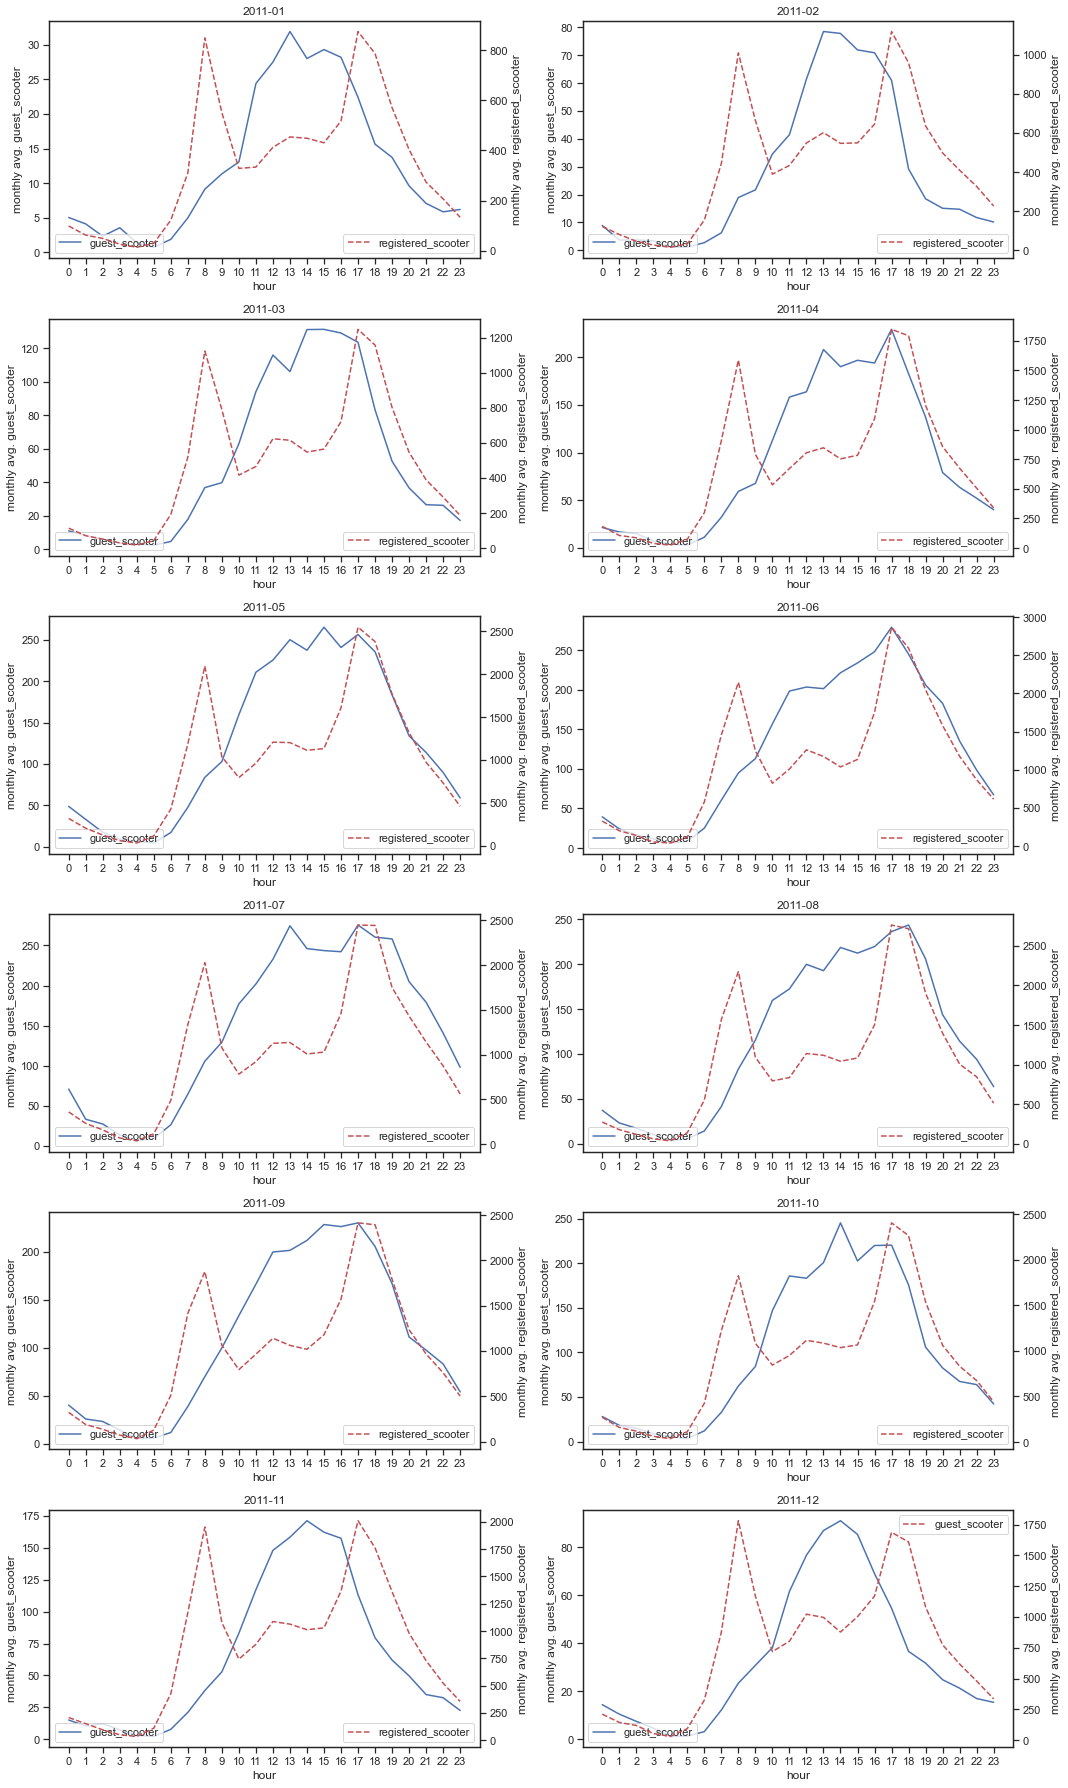

In [7]:
generate_avg_hourly_yyyymm_line_plots(df, 'guest_scooter','registered_scooter',2011)

#### Generate scatter plots to compare categorical data

## Weather vs Total E-Scooter Rentals
It looks like when the weather is clear, has the highest e-scooter ridership, followed by cloudy and light snow/rain. However when there is heavy weather, there is no/very few ridership

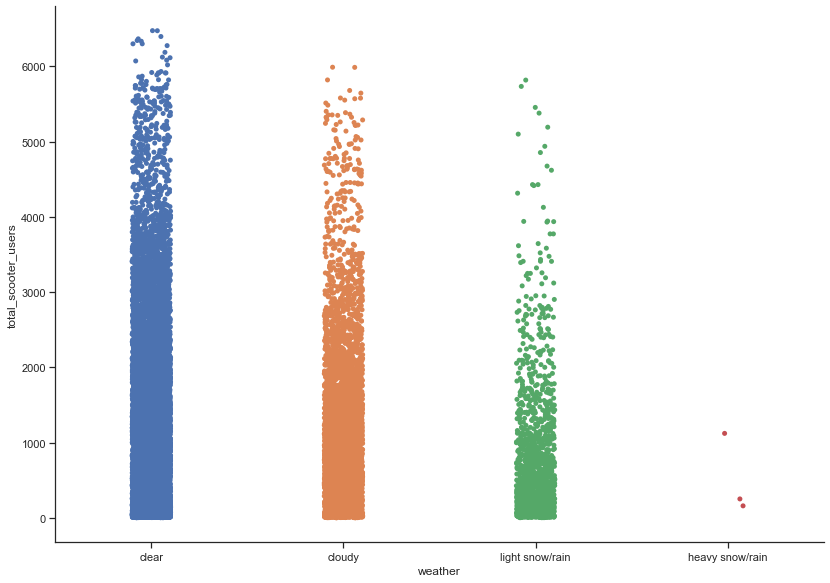

In [8]:
sns.catplot(x="weather", y="total_scooter_users", data=df, height=8.27, aspect=11.7/8.27)

###  Stationary Time Series
Upon further investigation, it looks like this dataset is a timeseries data, so I performed some further investigation on its properties. 

One property is to test if the time series is stationary, the Dickey-Fullter Test shows that if the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary

It looks like relative_humidity, windspeed and guest_scooter attributes are not stationary time series. Its possible relative humity and windspeed have seasonal behaviour, while guest_scooter has trending behaviour. Decomposition may be needed to remove seasonal and trending behavour from those datasets. 

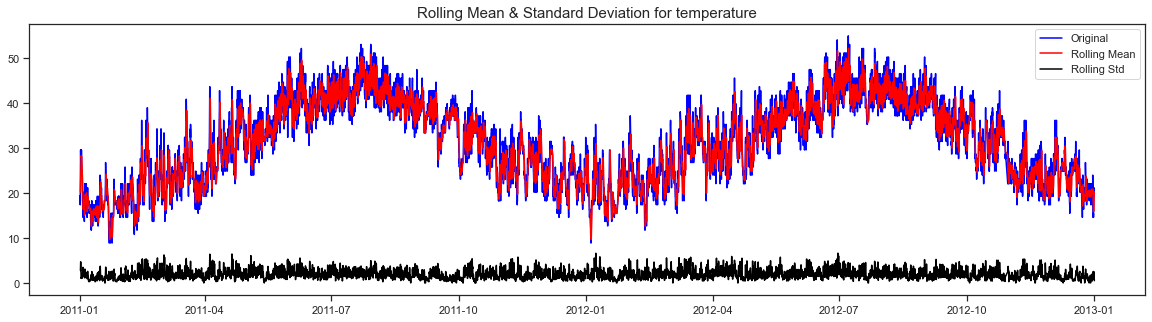

Results of Dickey-Fuller Test for temperature:
Test Statistic                    -3.984062
p-value                            0.001496
#Lags Used                        42.000000
Number of Observations Used    16988.000000
Critical Value (1%)               -3.430735
Critical Value (5%)               -2.861710
Critical Value (10%)              -2.566861
dtype: float64


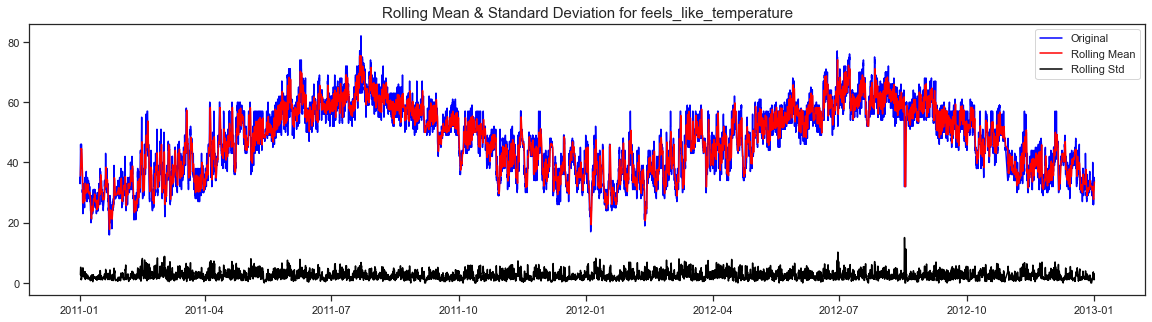

Results of Dickey-Fuller Test for feels_like_temperature:
Test Statistic                    -4.235926
p-value                            0.000572
#Lags Used                        44.000000
Number of Observations Used    16986.000000
Critical Value (1%)               -3.430735
Critical Value (5%)               -2.861710
Critical Value (10%)              -2.566861
dtype: float64


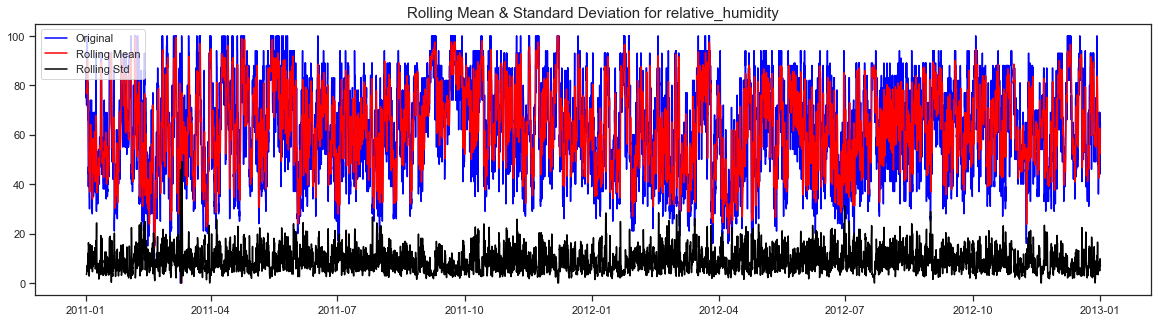

Results of Dickey-Fuller Test for relative_humidity:
Test Statistic                -1.153345e+01
p-value                        3.782793e-21
#Lags Used                     4.200000e+01
Number of Observations Used    1.698800e+04
Critical Value (1%)           -3.430735e+00
Critical Value (5%)           -2.861710e+00
Critical Value (10%)          -2.566861e+00
dtype: float64


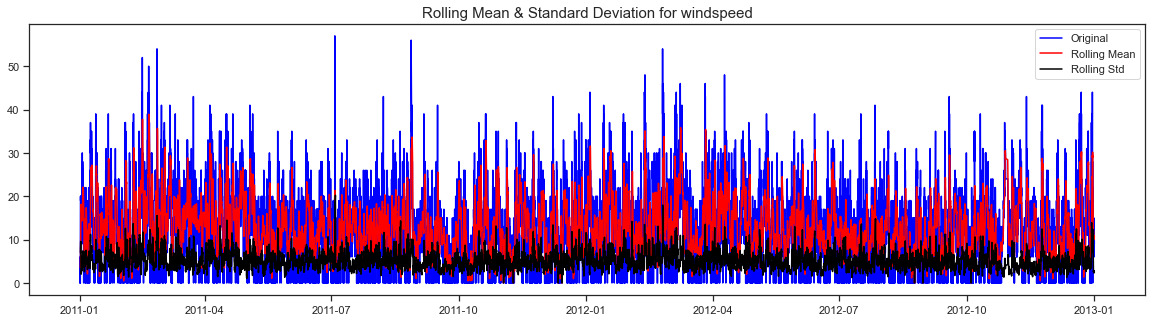

Results of Dickey-Fuller Test for windspeed:
Test Statistic                -1.548647e+01
p-value                        2.517022e-28
#Lags Used                     4.200000e+01
Number of Observations Used    1.698800e+04
Critical Value (1%)           -3.430735e+00
Critical Value (5%)           -2.861710e+00
Critical Value (10%)          -2.566861e+00
dtype: float64


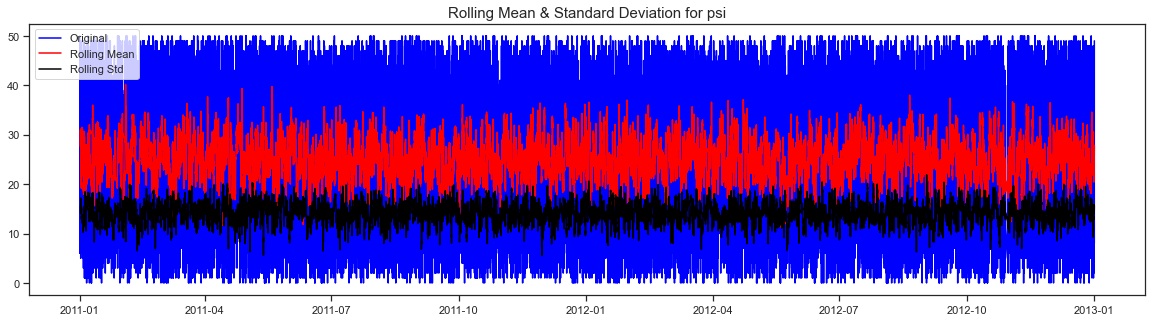

Results of Dickey-Fuller Test for psi:
Test Statistic                  -130.771893
p-value                            0.000000
#Lags Used                         0.000000
Number of Observations Used    17030.000000
Critical Value (1%)               -3.430734
Critical Value (5%)               -2.861710
Critical Value (10%)              -2.566860
dtype: float64


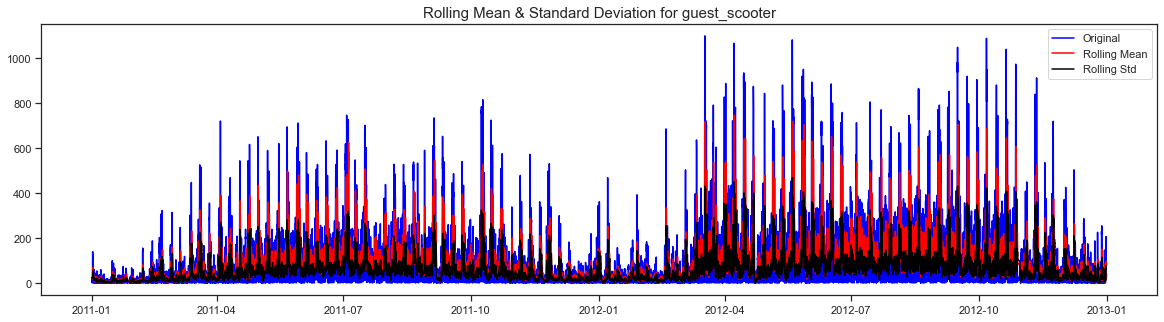

Results of Dickey-Fuller Test for guest_scooter:
Test Statistic                -1.369125e+01
p-value                        1.342624e-25
#Lags Used                     4.100000e+01
Number of Observations Used    1.698900e+04
Critical Value (1%)           -3.430735e+00
Critical Value (5%)           -2.861710e+00
Critical Value (10%)          -2.566861e+00
dtype: float64


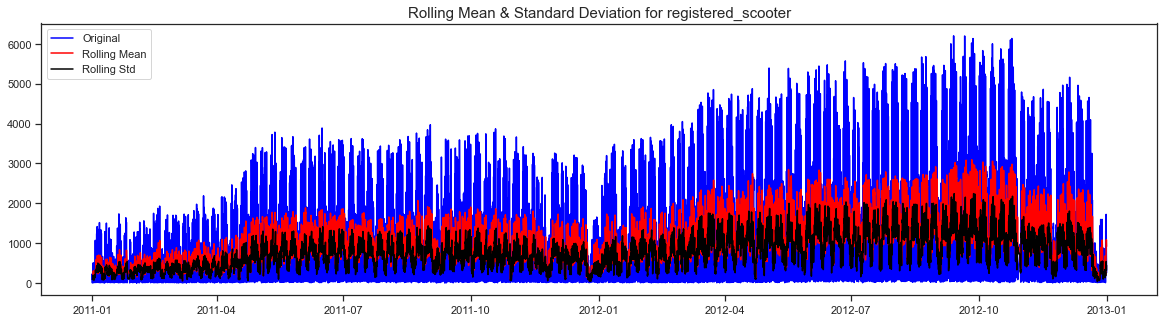

Results of Dickey-Fuller Test for registered_scooter:
Test Statistic                -7.648842e+00
p-value                        1.811961e-11
#Lags Used                     4.400000e+01
Number of Observations Used    1.698600e+04
Critical Value (1%)           -3.430735e+00
Critical Value (5%)           -2.861710e+00
Critical Value (10%)          -2.566861e+00
dtype: float64


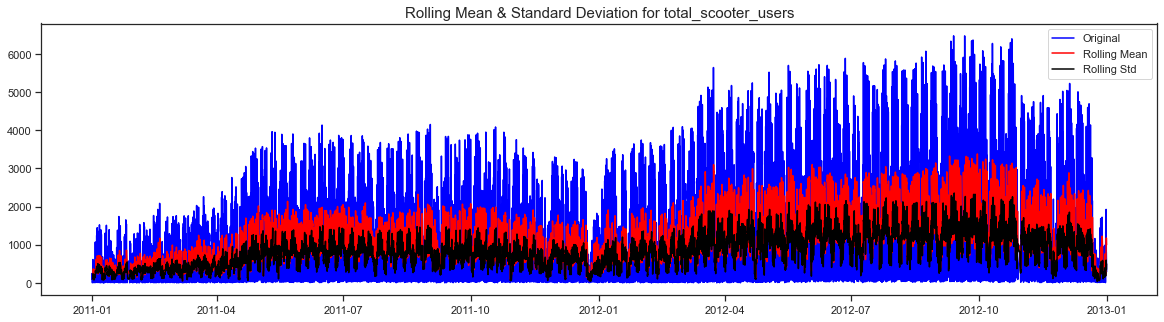

Results of Dickey-Fuller Test for total_scooter_users:
Test Statistic                -6.869741e+00
p-value                        1.526442e-09
#Lags Used                     4.400000e+01
Number of Observations Used    1.698600e+04
Critical Value (1%)           -3.430735e+00
Critical Value (5%)           -2.861710e+00
Critical Value (10%)          -2.566861e+00
dtype: float64


In [65]:
num = df._get_numeric_data()
columns = [x for x in num if 'hr' not in x]

for attribute in columns:
    test_stationarity(df,attribute,'2011-01-01','2012-12-31')

### Auto-Correlation Function  / Partial Auto-Correlation Function Plot

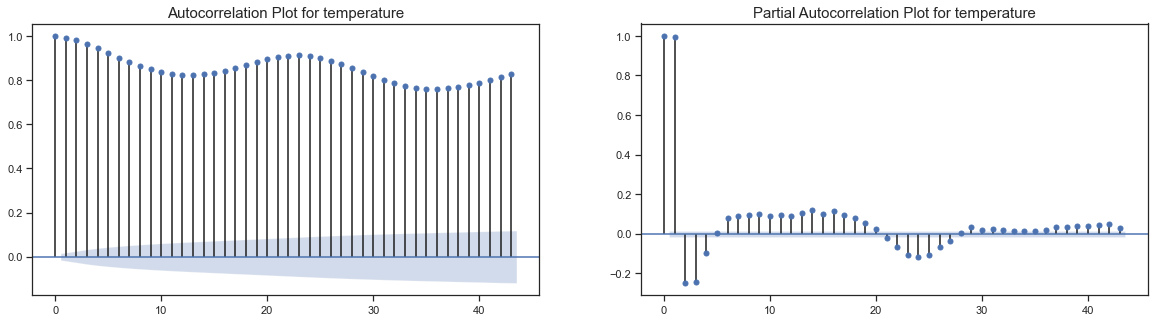

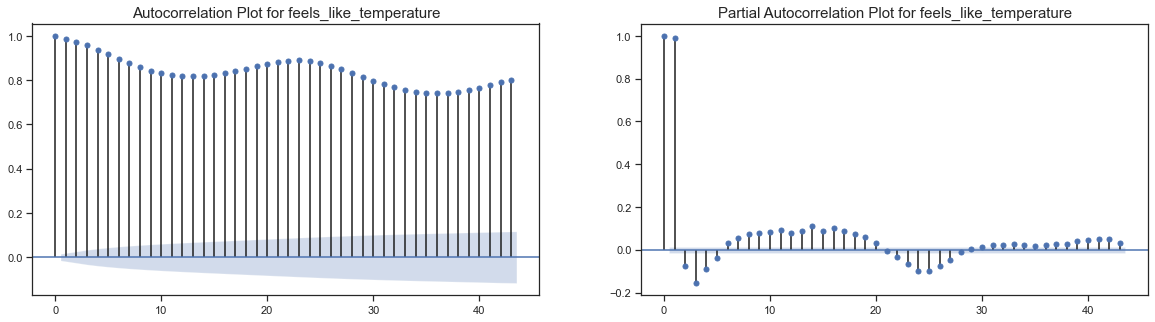

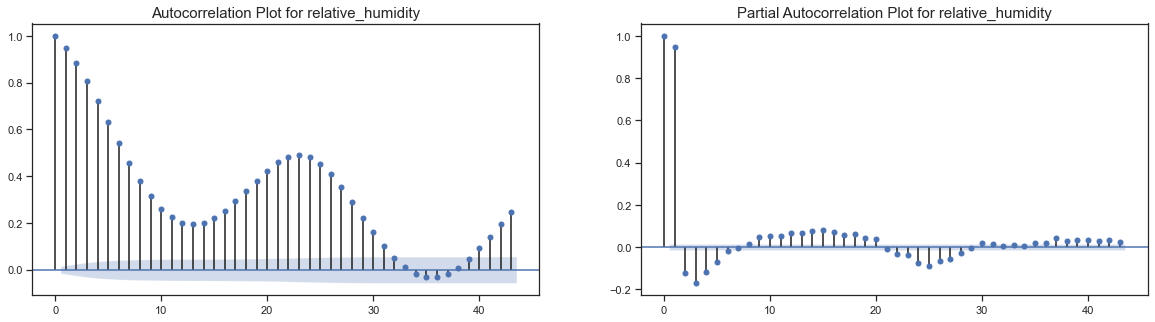

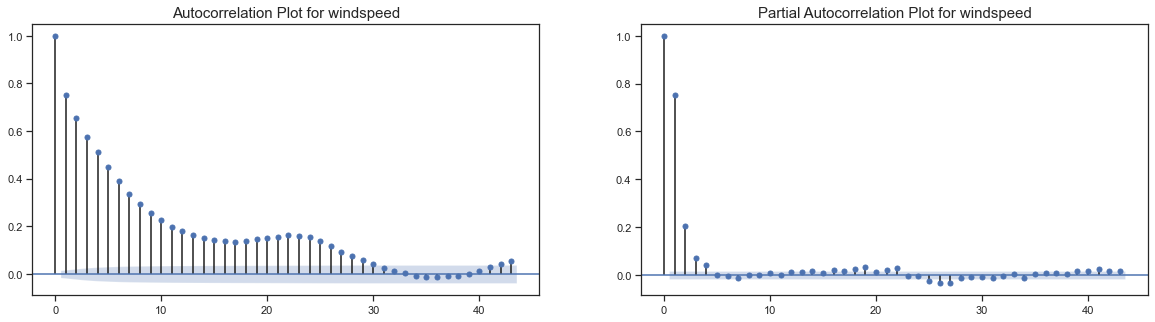

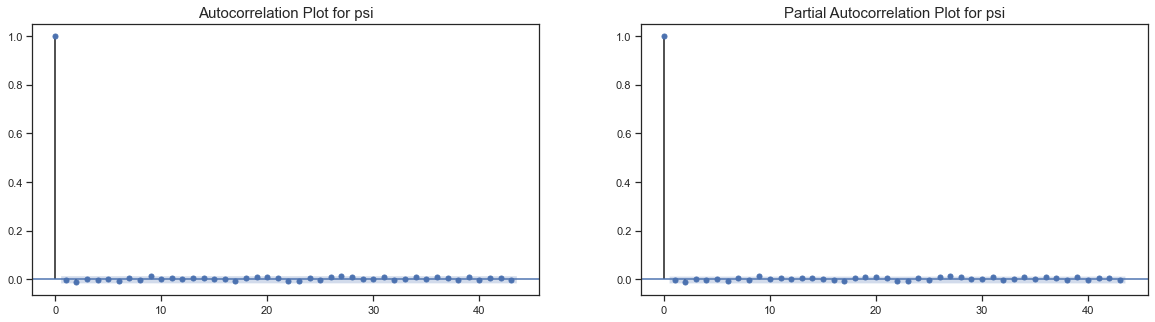

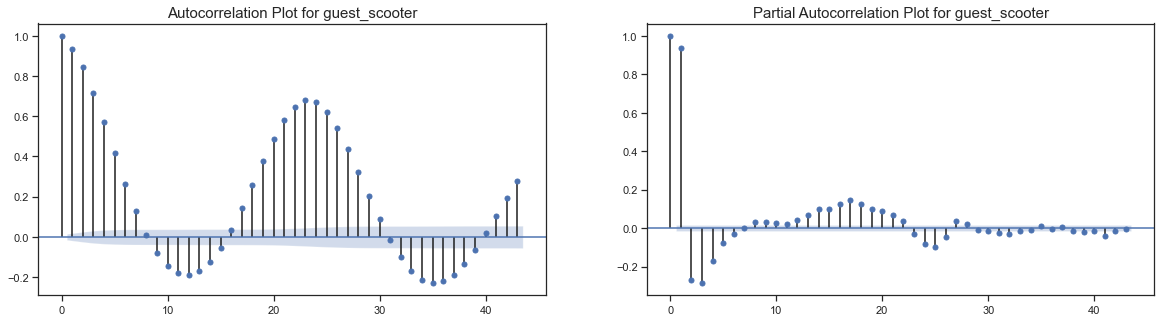

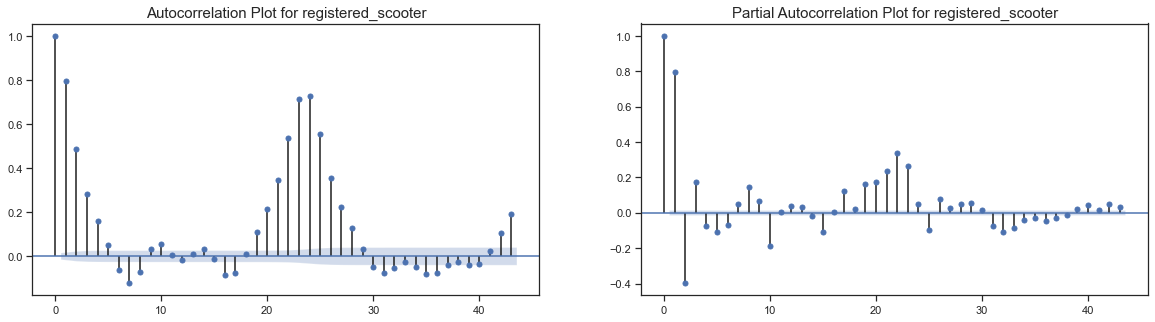

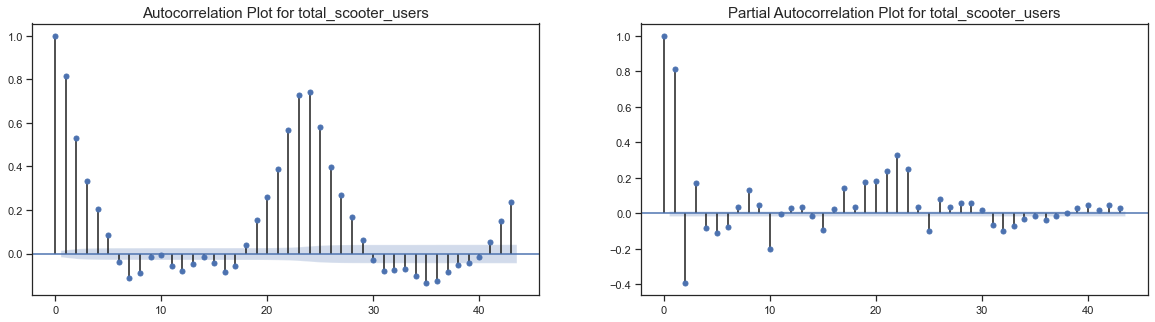

In [66]:
for attribute in columns:
    generate_autocorrelation_plot(df,attribute,'2011-01-01','2012-12-31')